# Analyzer

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib as mpl 
import seaborn as sns

mpl.rcParams['figure.dpi']= 200
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from skmisc.loess import loess

import statsmodels.api as sm
import statsmodels.formula.api as smf

import ipystata
from ipystata.config import config_stata  
config_stata('/Applications/Stata/StataMP.app/Contents/MacOS/stata-mp')  
from IPython.display import Image

from rpy2.robjects import pandas2ri
pandas2ri.activate()

%reload_ext rpy2.ipython

In [3]:
MAINDIR = os.getcwd().rsplit('/', 1)[0]
PATH = os.path.join(MAINDIR, 'data/analysis')

df = pd.read_pickle(os.path.join(PATH, 'vendor_week.pickle'))
df = df.merge(df.groupby('vendor')['me_min'].min().rename('me'), on = 'vendor')
df = df.rename(columns= {
    'international_shipment_count_w': 'int_shipment_count_w', 
    'international_shipment': 'int_shipment'})

In [4]:
cols = ['vendor', 'w', 'neg_count_w', 'pos_count_w', 'arf']
container = []
for vendor in [1, 61]:
    container.append(df.loc[df['vendor'] == vendor, cols].head())

pd.concat(container).reset_index(drop = True)

,vendor,w,neg_count_w,pos_count_w,arf
0,1,2,2.0,34.0,False
1,1,3,11.0,57.0,False
2,1,4,3.0,41.0,False
3,1,5,3.0,21.0,False
4,1,6,0.0,18.0,False
5,61,2,56.0,123.0,True
6,61,29,10.0,91.0,True
7,61,30,0.0,231.0,True
8,61,32,0.0,2.0,True
9,61,33,0.0,751.0,True


## Transform variables for analysis

In [5]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

# normalize variables
skewed_variables = [
    'neg_count_min', 'pos_count_min', 'neg_count_w', 
    'neg_count_w_shift', 'pos_count_w', 'pos_count_w_shift', 'sales_volume_w', 
    'item_count_w', 'int_shipment_count_w']

bc_vars = pd.DataFrame(
    pt.fit_transform(df[skewed_variables]),
    columns = ['bc_' + var for var in skewed_variables])

c_vars = df[skewed_variables].add_prefix('c_')

dummy_vars = df.assign(
        items   = pd.qcut(df['item_count'], 3,  labels=["low", "medium", "high"]),
        items_w = pd.qcut(df['item_count_w'], 3,  labels=["low", "medium", "high"]),
        sales   = pd.qcut(df['cum_count'], 2,  labels=["low", "high"]),
        sales_w = pd.qcut(df['sales_volume_w'], 2,  labels=["low", "high"]))\
    .loc[:,['items', 'items_w', 'sales', 'sales_w']]

n_vars = df[['cum_count', 'sales_volume_w', 'item_count', 
             'item_count_w', 'me', 'int_shipment_count_w',
             'empty_stock_last_week_count_w', 'empty_stock_last_week_maxw']].rename({'cum_count': 'sales_volume'})

bool_vars = df[
    ['arf', 'arm_maxw', 'arm_maxw_shift',
     'int_shipment', 'has_price_drop', 'has_price_drop_shift']].astype('int')

lev_vars =  df[['vendor','w', 'me_min']]

data = pd.concat([lev_vars, bool_vars, bc_vars, c_vars, dummy_vars, n_vars], axis = 1)

# Negative Feedbacks

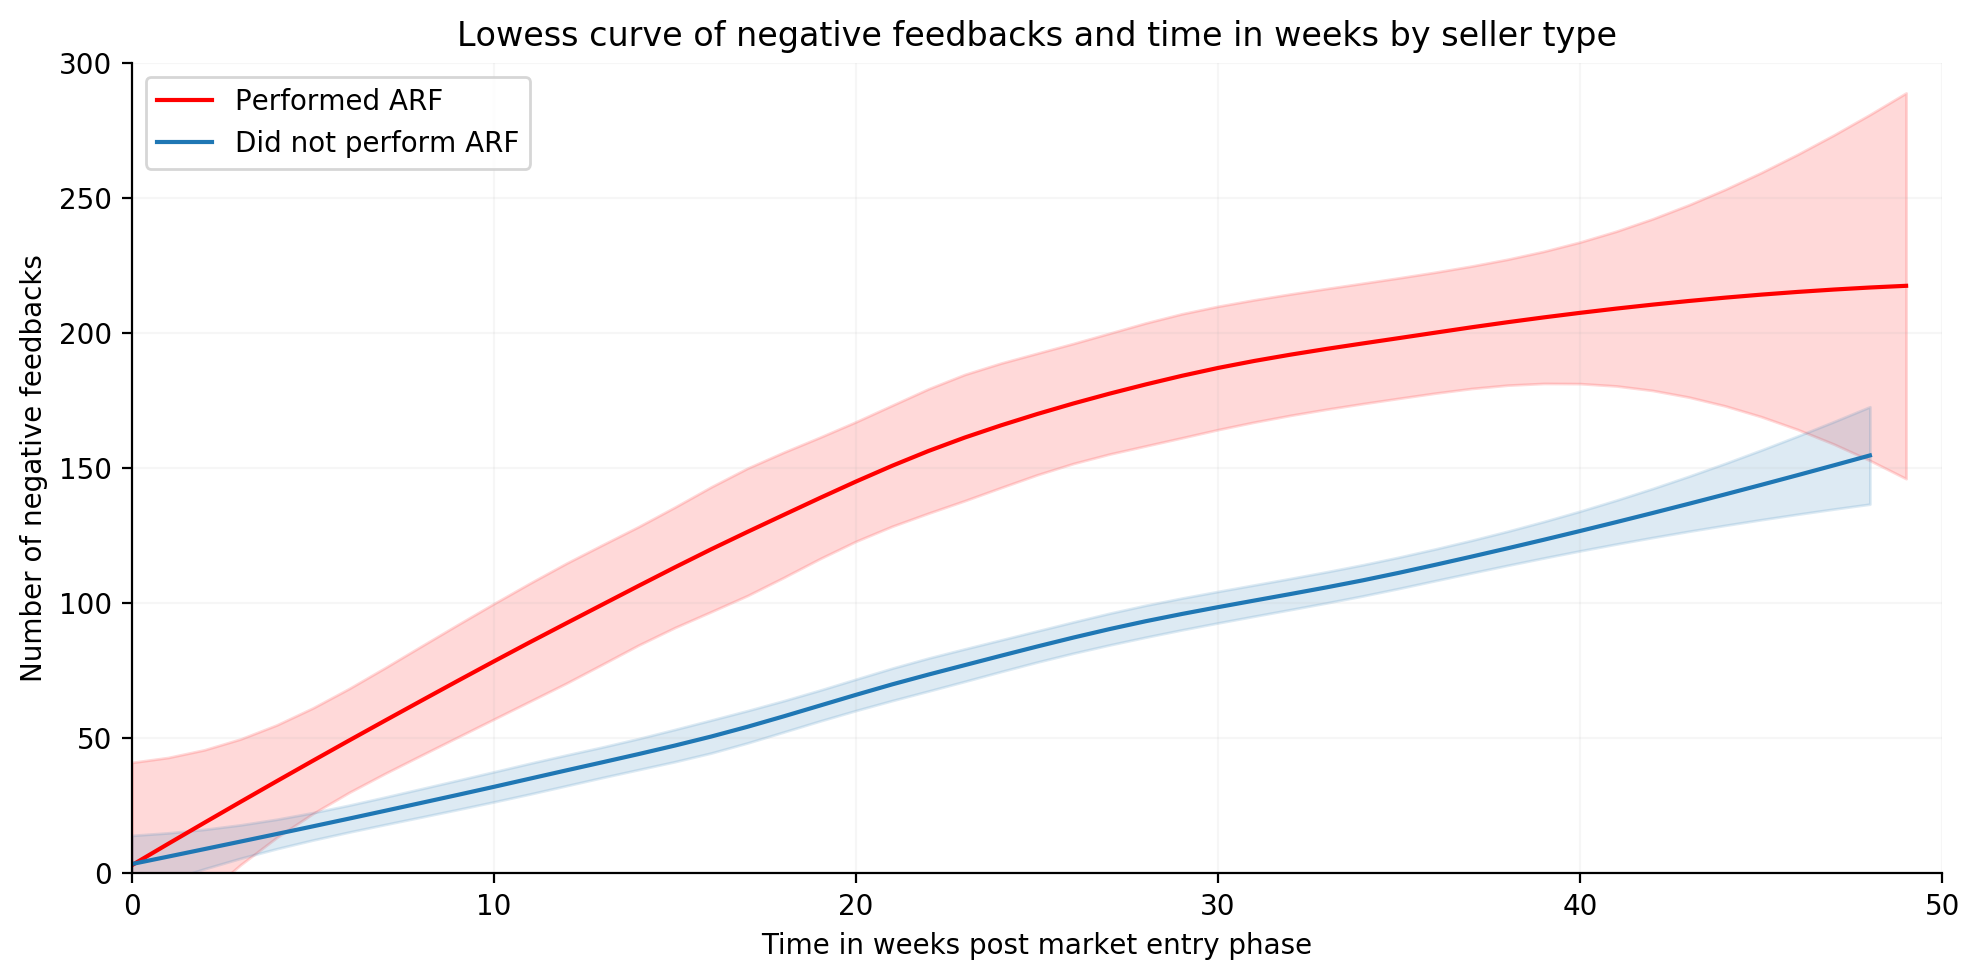

In [6]:
fig, ax = plt.subplots(figsize =  [10, 5])
ax.grid(True, which="both", ls="-", alpha = .1)

s = [df['arf'], ~df['arf']]
c = ['red', '#1f77b4']
l = ['Performed ARF', 'Did not perform ARF']

for selection, color, label in zip(s, c, l):
    # preprocess data
    d_ = df[selection].sort_values('w').copy()
    y = d_['neg_count_min'].to_numpy()
    x = d_['w'] - 2
    x_ = x.unique()

    # fit and predict lowess curve
    l = loess(x.to_numpy(), y, frac=0.1)
    l.fit()
    pred  = l.predict(x_, stderror=True)
    val   = pred.values
    conf  = pred.confidence()
    lower = conf.lower
    upper = conf.upper

    # plot lowess curve with 95% confidence
    ax.plot(x_, val, color=color, label = label)
    ax.fill_between(x_, lower, upper, alpha=.15, color=color)

ax.set_xlim(0, 50)
ax.set_ylim(0, 300)

# set titles and axes labels
ax.set_title('Lowess curve of negative feedbacks and time in weeks by seller type')
ax.set_ylabel('Number of negative feedbacks')
ax.set_xlabel('Time in weeks post market entry phase')
ax.legend(loc = 'upper left')

# show plot
plt.tight_layout()
plt.show()

## Importing R packages and developing custom ICC function

In [7]:
%%R

library('lme4')
library('margins')
library("performance")
library('tidyverse')

getICCs <- function(m, type = 'poisson'){
  var_s <- as.numeric(getME(m, "theta")[1]^2) # seller level variance
  var_w <- as.numeric(getME(m, "theta")[2]^2) # week level variance
  
  if(type == 'poisson'){
    lambda = .139
    alpha <- log(1 + 1/lambda)
  }
  if(type == 'binomial'){
    alpha <- (pi^2) / 3
  }
  
  icc <- list(
    s = (var_s)/ (var_s + var_w + alpha),
    w = (var_w)/ (var_s + var_w + alpha),
    t = (var_s + var_w)/ (var_s + var_w + alpha),
    a = (alpha)/ (var_s + var_w + alpha)
  )
  
  return(icc)
}


R[write to console]: Loading required package: Matrix

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()



## Standardizing and particioning variances for specified variables

In [8]:
%%R -i data

data['me_'] <- scale(data$me)[,1]
data['w_'] <- scale(data$w)[,1]
data['me_2'] <- scale(data$me^2)[,1]
data['w_2'] <- scale(data$w^2)[,1]

variables = c(
    'bc_pos_count_w', 'bc_item_count_w', 'bc_int_shipment_count_w',
    'bc_neg_count_w', 'c_neg_count_w', 'c_pos_count_w')

for (var in variables){
  for (vendor in unique(data$vendor)){
    # calculate mean and deviances
    x = data[data$vendor == vendor, var]
    m = mean(x)
    dev = x - m
    
    # concat information to dataframe
    data[data$vendor == vendor, paste(var, "m", sep=".")] <- m
    data[data$vendor == vendor, paste(var, "dev", sep=".")] <- dev
  }
}

In [9]:
%%R -o model1_fit

# Create empty list for results
model1 <- list()

# Baseline Model
model1 <- append(model1, 
                 list(a = glm(c_neg_count_w_shift ~ 1,
                              data, 
                              family = poisson)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# empty
model1 <- append(model1, 
                 list(b = glmer(c_neg_count_w_shift ~ 1
                                + (1 | vendor),
                                data, 
                                family = poisson)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# Including control variables
model1 <- append(model1, 
                 list(c = glmer(c_neg_count_w_shift ~ 1
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = poisson)))

icc1 <- getICCs(m = model1$c)

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# without interaction with bobyqa optimization
Optimizer <- glmerControl(optimizer = "bobyqa",
                          optCtrl = list(maxfun=2e5))

model1 <- append(model1, 
                 list(d = glmer(c_neg_count_w_shift ~ 
                                + bc_pos_count_w.m
                                + bc_pos_count_w.dev
                                + bc_item_count_w.m
                                + bc_item_count_w.dev
                                + bc_int_shipment_count_w.m
                                + bc_int_shipment_count_w.dev
                                + me_ + me_2 
                                + w_ + w_2 
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = poisson,
                                control = Optimizer)))


# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted)
# cross-level-interaction of ARF and Negative Feedbacks with 
# bobyqa optimization
model1 <- append(model1, 
                 list(e = glmer(c_neg_count_w_shift ~ arf
                                + bc_pos_count_w.m
                                + bc_pos_count_w.dev
                                + bc_item_count_w.m
                                + bc_item_count_w.dev
                                + bc_int_shipment_count_w.m
                                + bc_int_shipment_count_w.dev
                                + me_ + me_2 
                                + w_ + w_2 
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = poisson,
                                control = Optimizer)))

model1_fit<- round(data.frame(t(anova(model1$b, model1$c, model1$d, model1$e))), 3)

In [10]:
%%R -o model1_res

model1_res <- round(data.frame(summary(model1$e)[10]),3)
colnames(model1_res) <- c("B", 'se', 'z', 'p')
model1_res['or'] <- round(exp(model1_res$B), 3)

In [11]:
model1_fit

,model1.b,model1.c,model1.d,model1.e
npar,2.000,3.000,13.000,14.000
AIC,167577.677,148011.492,147344.941,147337.250
BIC,167593.744,148035.592,147449.376,147449.719
logLik,-83786.838,-74002.746,-73659.470,-73654.625
deviance,167573.677,148005.492,147318.941,147309.250
Chisq,NaN,19568.185,686.551,9.691
Df,NaN,1.000,10.000,1.000
Pr(>Chisq),NaN,0.000,0.000,0.002


In [12]:
def sig_stars(x):
    if x < .001: 
        return "***"
    if x < .01: 
        return "**"
    if x < .05:
        return "*"
    if x < .1: 
        return "."
    else: 
        return ""

model1_res[['B', 'or', 'se', 'p']]\
    .assign(star = lambda x: x['p'].apply(sig_stars))\
    .assign(coef = lambda x: x["B"].round(3).astype(str) + x["star"])[['coef', 'or', 'se', 'p']]

,coef,or,se,p
(Intercept),-0.46**,0.631,0.151,0.002
arf,0.474**,1.606,0.151,0.002
bc_pos_count_w.m,0.171,1.186,0.111,0.124
bc_pos_count_w.dev,0.042***,1.043,0.005,0.000
bc_item_count_w.m,0.613***,1.846,0.113,0.000
bc_item_count_w.dev,-0.165***,0.848,0.013,0.000
bc_int_shipment_count_w.m,0.404***,1.498,0.065,0.000
bc_int_shipment_count_w.dev,0.128***,1.137,0.021,0.000
me_,0.257.,1.293,0.132,0.052
me_2,-0.449***,0.638,0.121,0.000


# ARM

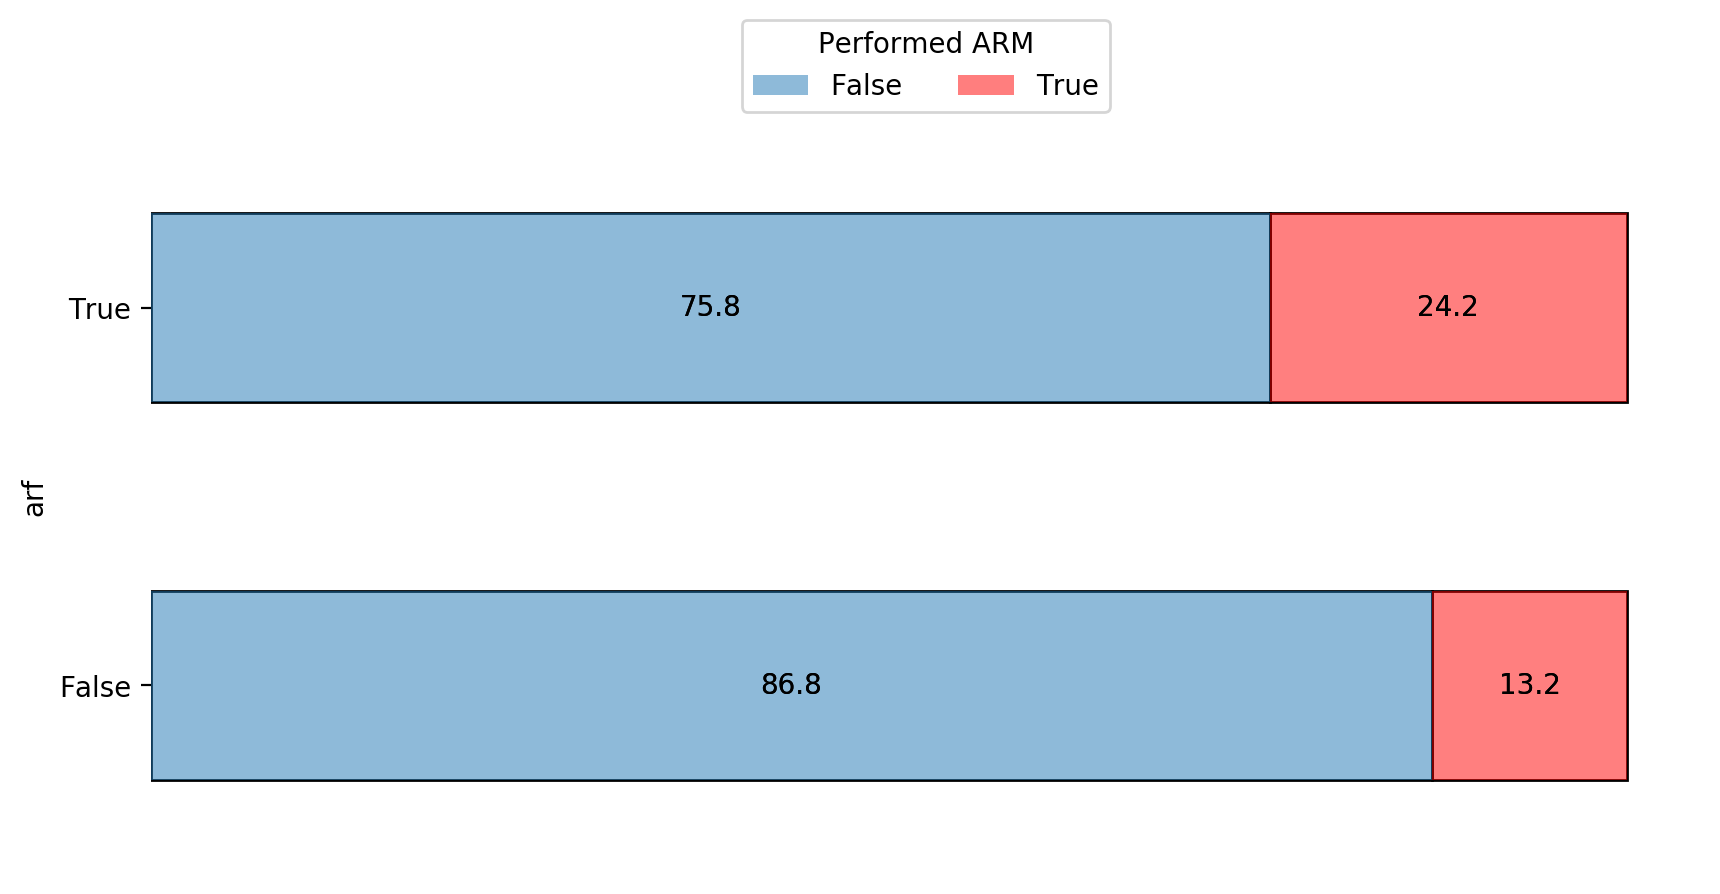

In [13]:
ct = pd.crosstab(df['arf'], df['arm_maxw_shift'], normalize = 'index')

fig, ax = plt.subplots(figsize =  [10, 5])
ax.invert_yaxis()

ct.plot.barh(stacked = True, 
             ax = ax, 
             edgecolor = 'black',
             color = ['none', 'none'])
ct.plot.barh(stacked = True, 
             ax = ax,
             rot = 0, 
             color = ['#1f77b4', 'red'],
             alpha = .5) 

# make legends for right panel 
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), 
          loc='upper center', bbox_to_anchor=(0.5, 1.15), 
          ncol = 2, title = 'Performed ARM')

# Value labels
patches = ax.patches
for rect in patches:
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., round(width*100, 1), ha='center', va='center')

ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.show()

In [14]:
%%R -o model2_fit

# Create empty list for results
model2 <- list()

# Baseline Model
model2 <- append(model2, 
                 list(a = glm(arm_maxw_shift ~ 1,
                              data, 
                              family = binomial)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# empty
model2 <- append(model2, 
                 list(b = glmer(arm_maxw_shift ~ 1
                                + (1 | vendor),
                                data, 
                                family = binomial)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# Including control variables
model2 <- append(model2, 
                 list(c = glmer(arm_maxw_shift ~ 1
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial)))

icc2 <- getICCs(model2$c, 'binomial')

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# without interaction with bobyqa optimization
Optimizer <- glmerControl(optimizer = "bobyqa",
                          optCtrl = list(maxfun=2e5))

model2 <- append(model2, 
                 list(d = glmer(arm_maxw_shift ~ 
                                + bc_pos_count_w.m
                                + bc_pos_count_w.dev
                                + bc_item_count_w.m
                                + bc_item_count_w.dev
                                + bc_int_shipment_count_w.m
                                + bc_int_shipment_count_w.dev
                                + me_ + me_2 
                                + w_ + w_2 
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial,
                                control = Optimizer)))


# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted)
# cross-level-interaction of ARF and Negative Feedbacks with 
# bobyqa optimization
model2 <- append(model2, 
                 list(e = glmer(arm_maxw_shift ~ arf
                                + bc_neg_count_w.m
                                + bc_neg_count_w.dev
                                + bc_neg_count_w.m:arf
                                + bc_neg_count_w.dev:arf
                                + bc_pos_count_w.m
                                + bc_pos_count_w.dev
                                + bc_item_count_w.m
                                + bc_item_count_w.dev
                                + bc_int_shipment_count_w.m
                                + bc_int_shipment_count_w.dev
                                + me_ + me_2 
                                + w_ + w_2 
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial, 
                                control = Optimizer)))

model2_fit<- round(data.frame(t(anova(model2$b, model2$c, model2$d, model2$e))), 3)

In [15]:
%%R -o model2_res

model2_res <- round(data.frame(summary(model2$e)[10]),3)
colnames(model2_res) <- c("B", 'se', 'z', 'p')
model2_res['or'] <- round(exp(model2_res$B), 3)

In [16]:
model2_fit

,model2.b,model2.c,model2.d,model2.e
npar,2.000,3.000,13.000,18.000
AIC,10767.511,10644.645,6441.765,6397.763
BIC,10783.578,10668.746,6546.200,6542.366
logLik,-5381.755,-5319.323,-3207.882,-3180.882
deviance,10763.511,10638.645,6415.765,6361.763
Chisq,NaN,124.865,4222.881,54.001
Df,NaN,1.000,10.000,5.000
Pr(>Chisq),NaN,0.000,0.000,0.000


In [17]:
model2_res[['B', 'or', 'se', 'p']]\
    .assign(star = lambda x: x['p'].apply(sig_stars))\
    .assign(coef = lambda x: x["B"].round(3).astype(str) + x["star"])[['coef', 'or', 'se', 'p']]

,coef,or,se,p
(Intercept),-6.493***,0.002,0.169,0.000
arf,0.816**,2.261,0.269,0.002
bc_neg_count_w.m,0.909***,2.482,0.157,0.000
bc_neg_count_w.dev,0.056,1.058,0.045,0.215
bc_pos_count_w.m,3.535***,34.295,0.226,0.000
bc_pos_count_w.dev,4.562***,95.775,0.131,0.000
bc_item_count_w.m,2.256***,9.545,0.213,0.000
bc_item_count_w.dev,0.534***,1.706,0.135,0.000
bc_int_shipment_count_w.m,-0.123,0.884,0.103,0.234
bc_int_shipment_count_w.dev,0.046,1.047,0.188,0.808


## Selling Price Adjustment

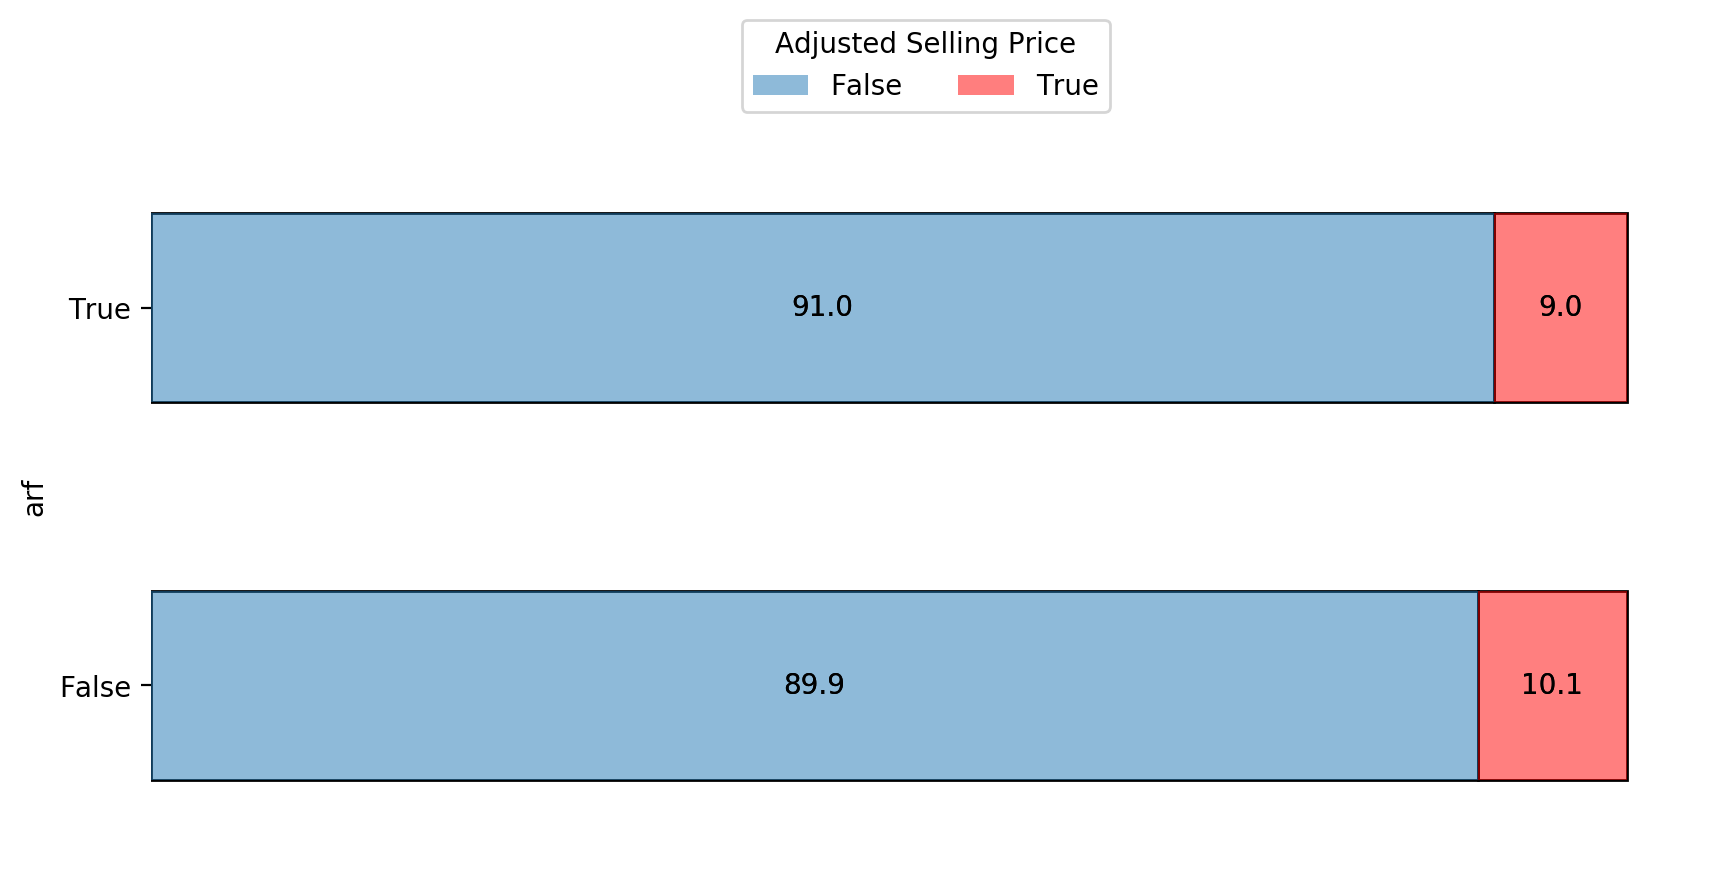

In [18]:
ct = pd.crosstab(df['arf'], df['has_price_drop_shift'], normalize = 'index')

fig, ax = plt.subplots(figsize =  [10, 5])
ct.plot.barh(stacked = True, 
             ax = ax, 
             edgecolor = 'black',
             color = ['none', 'none'])
ct.plot.barh(stacked = True, 
             ax = ax,
             rot = 0, 
             color = ['#1f77b4', 'red'],
             alpha = .5)
ax.invert_yaxis() 

# make legends for right panel 
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol = 2, title = 'Adjusted Selling Price')

# Value labels
patches = ax.patches
for rect in patches:
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., round(width*100, 1), ha='center', va='center')
        
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.invert_yaxis()
plt.xticks([])
plt.show()

In [19]:
%%R -o model3_fit

# Create empty list for results
model3 <- list()

# Baseline Model
model3 <- append(model3, 
                 list(a = glm(has_price_drop_shift ~ 1,
                              data, 
                              family = binomial)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# empty
model3 <- append(model3, 
                 list(b = glmer(has_price_drop_shift ~ 1
                                + (1 | vendor),
                                data, 
                                family = binomial)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# Including control variables
model3 <- append(model3, 
                 list(c = glmer(has_price_drop_shift ~ 1
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial)))

icc3 <- getICCs(model3$c, 'binomial')

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# without interaction
Optimizer <- glmerControl(optimizer = "bobyqa",
                          optCtrl = list(maxfun=2e5))
model3 <- append(model3, 
                 list(d = glmer(has_price_drop_shift ~
                                + bc_pos_count_w.m
                                + bc_pos_count_w.dev
                                + bc_item_count_w.m
                                + bc_item_count_w.dev
                                + bc_int_shipment_count_w.m
                                + bc_int_shipment_count_w.dev
                                + me_ + me_2 
                                + w_ + w_2 
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial,
                                control = Optimizer)))


# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted)
# cross-level-interaction of ARF and Negative Feedbacks
model3 <- append(model3, 
                 list(e = glmer(has_price_drop_shift ~ arf
                                + bc_neg_count_w.m
                                + bc_neg_count_w.dev
                                + bc_neg_count_w.m:arf
                                + bc_neg_count_w.dev:arf
                                + bc_pos_count_w.m
                                + bc_pos_count_w.dev
                                + bc_item_count_w.m
                                + bc_item_count_w.dev
                                + bc_int_shipment_count_w.m
                                + bc_int_shipment_count_w.dev
                                + me_ + me_2 
                                + w_ + w_2 
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial, 
                                control = Optimizer)))

model3_fit<- round(data.frame(t(anova(model3$b, model3$c, model3$d, model3$e))), 3)

In [20]:
%%R -o model3_res

model3_res <- round(data.frame(summary(model3$e)[10]),3)
colnames(model3_res) <- c("B", 'se', 'z', 'p')
model3_res['or'] <- round(exp(model3_res$B), 3)

In [21]:
model3_fit

,model3.b,model3.c,model3.d,model3.e
npar,2.000,3.000,13.000,18.000
AIC,14743.201,14057.548,13679.326,13680.478
BIC,14759.268,14081.648,13783.762,13825.082
logLik,-7369.600,-7025.774,-6826.663,-6822.239
deviance,14739.201,14051.548,13653.326,13644.478
Chisq,NaN,687.653,398.222,8.848
Df,NaN,1.000,10.000,5.000
Pr(>Chisq),NaN,0.000,0.000,0.115


In [22]:
model3_res\
    .assign(star = lambda x: x['p'].apply(sig_stars))\
    .assign(coef = lambda x: x["B"].round(3).astype(str) + x["star"])[['coef','or', 'se', 'p']]

,coef,or,se,p
(Intercept),-2.501***,0.082,0.106,0.000
arf,0.01,1.010,0.073,0.891
bc_neg_count_w.m,-0.122*,0.885,0.049,0.013
bc_neg_count_w.dev,-0.023,0.977,0.033,0.476
bc_pos_count_w.m,-0.401***,0.670,0.059,0.000
bc_pos_count_w.dev,-0.412***,0.662,0.040,0.000
bc_item_count_w.m,-0.039,0.962,0.057,0.497
bc_item_count_w.dev,-0.058,0.944,0.065,0.372
bc_int_shipment_count_w.m,0.041,1.042,0.032,0.201
bc_int_shipment_count_w.dev,0.3*,1.350,0.116,0.010
